In [0]:
from google.colab import files
files.upload()

In [2]:
!mkdir /root/.kaggle
!mv kaggle.json /root/.kaggle/
!kaggle competitions download -c tgs-salt-identification-challenge
!unzip -q train.zip
!unzip -q test.zip
!rm train.zip test.zip

  0% 0.00/322k [00:00<?, ?B/s]
100% 322k/322k [00:00<00:00, 47.2MB/s]
  0% 0.00/264k [00:00<?, ?B/s]
100% 264k/264k [00:00<00:00, 83.8MB/s]
  0% 0.00/922k [00:00<?, ?B/s]
100% 922k/922k [00:00<00:00, 59.2MB/s]
 89% 145M/163M [00:01<00:00, 109MB/s]
100% 163M/163M [00:01<00:00, 121MB/s]
 95% 36.0M/37.9M [00:00<00:00, 47.6MB/s]
100% 37.9M/37.9M [00:00<00:00, 95.8MB/s]


### TGT Salt Classification Challenge


In [0]:
import numpy as np
import gc
import cv2
def rle_to_output(x):
  if type(x)!=np.float:
    x = list(map(int, x.split(' ')))
    out = np.zeros(101*101,dtype=np.int64)
    for i in range(0,len(x),2):
      out[ x[i]-1:x[i+1]+x[i]-1 ] = 1
    return np.reshape(np.array(out),(101,101)).T
  else:
    return np.zeros((128,128),dtype=np.int64)

In [2]:
import glob
import pandas as pd

data = pd.read_csv('train.csv')
depths = pd.read_csv('depths.csv')
data = pd.merge(data,depths,on='id',how='left')
X = data.id.apply(lambda x: "images/"+str(x)+'.png')
Y = data.id.apply(lambda x: "masks/"+str(x)+'.png')
Z = data.z
data.head(5)

,id,rle_mask,z
0,575d24d81d,NaN,843
1,a266a2a9df,5051 5151,794
2,75efad62c1,9 93 109 94 210 94 310 95 411 95 511 96 612 96...,468
3,34e51dba6a,48 54 149 54 251 53 353 52 455 51 557 50 659 4...,727
4,4875705fb0,1111 1 1212 1 1313 1 1414 1 1514 2 1615 2 1716...,797


### Basic Visualization

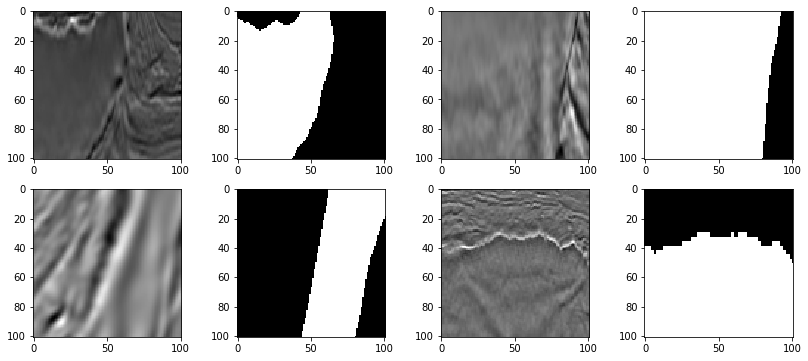

In [3]:
import matplotlib.pyplot as plt
import cv2
%matplotlib inline
fig,ax = plt.subplots(nrows=2,ncols=4,figsize=(14,6))
indexs=[15,511,1130,3452]
for index,l in zip(indexs,[(0,0),(0,2),(1,0),(1,2)]):
  ax[l[0]][l[1]].imshow( cv2.imread(X[index]) )
  ax[l[0]][l[1]+1].imshow( cv2.imread(Y[index]) )

In [4]:
all_images = glob.glob('masks/*')
print(len(all_images), X.shape)

IMG_DIM = (128,128,3)

from keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator, array_to_img
X = np.array([ img_to_array( load_img(file, target_size = IMG_DIM ) ) for file in X.values ])
Y = np.array([ img_to_array( load_img(file, target_size = (128,128,1), color_mode='grayscale' ) ) for file in Y.values ])/255

print(X.shape,Y.shape,Z.shape)

4000 (4000,)


Using TensorFlow backend.


(4000, 128, 128, 3) (4000, 128, 128, 1) (4000,)


In [0]:
from sklearn.model_selection import train_test_split, StratifiedKFold
#X_train,X_val,Y_train,Y_val = train_test_split(X,Y,test_size=0.2)

train_datagen = ImageDataGenerator(rescale=1./255, 
                                   brightness_range=(0.5,1.25),
                                   zoom_range=[.80,1.20],
                                   fill_mode='nearest')
val_datagen = ImageDataGenerator(rescale=1./255)

skf = StratifiedKFold(n_splits=5,shuffle=True,random_state=5,)

#train_generator = train_datagen.flow(X_train, Y_train, batch_size=32)
#val_generator = val_datagen.flow(X_val, Y_val, batch_size=32)

### Implementing a Fully Convolutional Network called UNET for Image Segmentation

In [6]:
from keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Dropout
from keras import optimizers
from keras.applications import VGG16
from keras.models import Model

vgg = VGG16(weights='imagenet',include_top=False, input_shape=IMG_DIM)
vgg.layers.pop()
vgg.trainable=False
for layer in vgg.layers[:-7]:
    layer.trainable = False

def conv2d_block( input_tensor, n_filters, kernel_size = (3,3)):
  "Add 2 conv layer"
  x = Conv2D(filters=n_filters, kernel_size=kernel_size, kernel_initializer='he_normal', 
             padding='same',activation="relu")(input_tensor)
  
  x = Conv2D(filters=n_filters, kernel_size=kernel_size, kernel_initializer='he_normal', 
             padding='same',activation="relu")(x)
  return x

u1 = Conv2DTranspose(512, (3, 3), strides = (2, 2), padding = 'same')(vgg.get_layer('block5_conv3').output)
u1 = concatenate([u1,vgg.get_layer('block4_conv3').output])
u1 = Dropout(0.1)(u1)
c1 = conv2d_block(u1, 512)

u2 = Conv2DTranspose(256, (3, 3), strides = (2, 2), padding = 'same')(c1)
u2 = concatenate([u2,vgg.get_layer('block3_conv3').output])
u2 = Dropout(0.1)(u2)
c2 = conv2d_block(u2, 256)

u3 = Conv2DTranspose(128, (3, 3), strides = (2, 2), padding = 'same')(c2)
u3 = concatenate([u3,vgg.get_layer('block2_conv2').output])
u3 = Dropout(0.1)(u3)
c3 = conv2d_block(u3, 128)

u4 = Conv2DTranspose(64, (3, 3), strides = (2, 2), padding = 'same')(c3)
u4 = concatenate([u4,vgg.get_layer('block1_conv2').output])
u4 = Dropout(0.1)(u4)
c4 = conv2d_block(u4, 64)

output = Conv2D(1, (1, 1), activation='sigmoid')(c4)

unets= []

for _ in range(5):
  unet = Model(vgg.input, output)
  unet.compile(optimizer=optimizers.Adam(lr=1e-3), loss='binary_crossentropy', metrics=['accuracy'])
  unets.append(unet)

unets[0].summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 128, 128, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 128, 128, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooli

In [7]:
layers = [(layer, layer.name,layer.trainable) for layer in unets[0].layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at...,input_1,False
1,<keras.layers.convolutional.Conv2D object at 0...,block1_conv1,False
2,<keras.layers.convolutional.Conv2D object at 0...,block1_conv2,False
3,<keras.layers.pooling.MaxPooling2D object at 0...,block1_pool,False
4,<keras.layers.convolutional.Conv2D object at 0...,block2_conv1,False
5,<keras.layers.convolutional.Conv2D object at 0...,block2_conv2,False
6,<keras.layers.pooling.MaxPooling2D object at 0...,block2_pool,False
7,<keras.layers.convolutional.Conv2D object at 0...,block3_conv1,False
8,<keras.layers.convolutional.Conv2D object at 0...,block3_conv2,False
9,<keras.layers.convolutional.Conv2D object at 0...,block3_conv3,False


In [8]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import LabelEncoder

model_checkpoint  = ModelCheckpoint('model_best_checkpoint.h5', save_best_only=True, monitor='val_loss', mode='min', verbose=0)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min')
reduceLR = ReduceLROnPlateau(patience=4, verbose=0, monitor='val_loss',min_lr=1e-4)

callback_list = [model_checkpoint,early_stopping, reduceLR]

i=1
for train_index, test_index in skf.split(X, LabelEncoder().fit_transform(pd.qcut(Z,5))):
      train_generator = train_datagen.flow(X[train_index], Y[train_index], batch_size=32)
      val_generator = val_datagen.flow(X[test_index], Y[test_index], batch_size=32)
      print("----------------------------------Training {} UNET-----------------------".format(i))
      history = unets[i-1].fit_generator(train_generator, steps_per_epoch=20, epochs=150,
                              validation_data=val_generator, validation_steps=15, 
                              verbose=2,callbacks=callback_list)
      i+=1

----------------------------------Training 1 UNET-----------------------
Instructions for updating:
Use tf.cast instead.
Epoch 1/150
 - 20s - loss: 0.9399 - acc: 0.6926 - val_loss: 0.4272 - val_acc: 0.8264
Epoch 2/150
 - 11s - loss: 0.4707 - acc: 0.8030 - val_loss: 0.4331 - val_acc: 0.8115
Epoch 3/150
 - 10s - loss: 0.4494 - acc: 0.8053 - val_loss: 0.3627 - val_acc: 0.8633
Epoch 4/150
 - 10s - loss: 0.3771 - acc: 0.8495 - val_loss: 0.3441 - val_acc: 0.8584
Epoch 5/150
 - 16s - loss: 0.3487 - acc: 0.8605 - val_loss: 0.2975 - val_acc: 0.8912
Epoch 6/150
 - 10s - loss: 0.3639 - acc: 0.8600 - val_loss: 0.3449 - val_acc: 0.8491
Epoch 7/150
 - 10s - loss: 0.3579 - acc: 0.8592 - val_loss: 0.3093 - val_acc: 0.8875
Epoch 8/150
 - 10s - loss: 0.3418 - acc: 0.8618 - val_loss: 0.2837 - val_acc: 0.8897
Epoch 9/150
 - 10s - loss: 0.3589 - acc: 0.8553 - val_loss: 0.2927 - val_acc: 0.8834
Epoch 10/150
 - 10s - loss: 0.3354 - acc: 0.8696 - val_loss: 0.2990 - val_acc: 0.8880
Epoch 11/150
 - 10s - loss: 

In [9]:
del X,Y; gc.collect()

80

### Model Performance
1. Loss : 0.21
2. Acc : 0.90

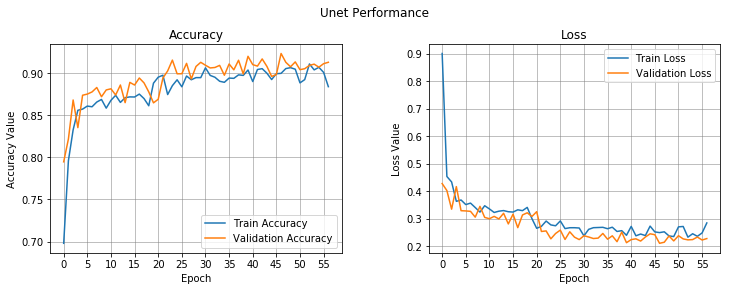

In [0]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Unet Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)


epoch_list = history.epoch
ax1.plot(epoch_list, history.history['acc'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_acc'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, epoch_list[-1], 5))
ax1.set_ylabel('Accuracy Value');ax1.set_xlabel('Epoch');ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best");ax1.grid(color='gray', linestyle='-', linewidth=0.5)

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, epoch_list[-1], 5))
ax2.set_ylabel('Loss Value');ax2.set_xlabel('Epoch');ax2.set_title('Loss')
l2 = ax2.legend(loc="best");ax2.grid(color='gray', linestyle='-', linewidth=0.5)

## To Submit

In [0]:
from keras.models import load_model
#unet = load_model('model_best_checkpoint.h5')

In [10]:
submission = pd.read_csv('sample_submission.csv',usecols=['id'])
submission.head()

,id
0,155410d6fa
1,78b32781d1
2,63db2a476a
3,17bfcdb967
4,7ea0fd3c88


In [0]:
output = [ 'images/{}.png'.format(i) for i in submission.id.values ]
output = np.array([ img_to_array( load_img(file, target_size = IMG_DIM ) ) for file in output ])
output = np.array(output)

In [15]:
outputs = unets[0].predict(output)
for unet in unets[1:]:
  print("Added")
  outputs+=unet.predict(output)
outputs/=5
del output; gc.collect()

191

In [0]:
def process_output(out):
  im = cv2.resize(out, (101,101), interpolation = cv2.INTER_AREA)
  return (np.squeeze(im)>0.5)*1

def rle_encode(im):
  im = im.T
  im = np.reshape(im,(101*101))
  pixels = im.flatten(order = 'F')
  pixels = np.concatenate([[0], pixels, [0]])
  runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
  runs[1::2] -= runs[::2]
  return ' '.join(str(x) for x in runs)

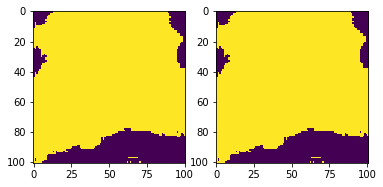

In [17]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 4))
im = cv2.resize(outputs[0], (101,101), interpolation = cv2.INTER_AREA)
im = (np.squeeze(im)>0.5)*1
ax1.imshow(im)
im = rle_encode(im)
im = rle_to_output(im)
ax2.imshow(im)

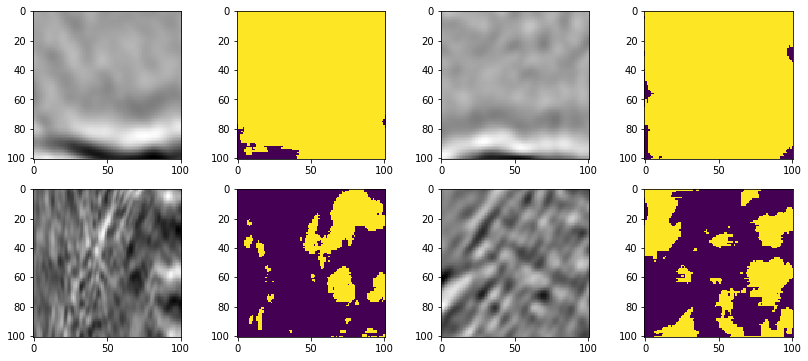

In [18]:
fig,ax = plt.subplots(nrows=2,ncols=4,figsize=(14,6))
indexs=[145,678,1456,13453]
for index,l in zip(indexs,[(0,0),(0,2),(1,0),(1,2)]):
  im = cv2.imread("images/{}.png".format(submission.iloc[index].id))
  ax[l[0]][l[1]].imshow(im)
  ax[l[0]][l[1]+1].imshow(process_output(outputs[index]))

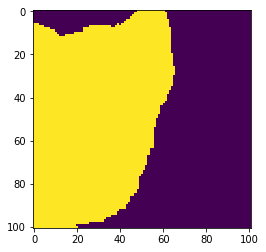

In [19]:
img = np.array([ img_to_array( load_img('images/'+data.iloc[15].id+'.png', target_size = IMG_DIM ) ) ])/255
temp = np.zeros((1,128,128,1))
for unet in unets: temp += unet.predict(img)
temp/=5
plt.imshow(process_output(temp[0]))

In [20]:
submission['rle_mask'] = [ rle_encode(process_output(o)) for o in outputs ]
submission.head()

,id,rle_mask
0,155410d6fa,13 13 45 57 110 18 143 57 202 1 213 14 245 59 ...
1,78b32781d1,62 37 162 38 263 39 363 42 462 44 562 45 659 4...
2,63db2a476a,740 1 840 2 845 3 941 2 946 3 1040 3 1049 1 11...
3,17bfcdb967,100 2 199 1 201 2 300 1 302 2 401 4 501 5 602 ...
4,7ea0fd3c88,3838 1 3939 1 4040 1 4137 2 4140 2 4238 5 4338...


In [0]:
submission.to_csv('submission.csv',index=False)

In [23]:
!kaggle competitions submit -c tgs-salt-identification-challenge -f submission.csv -m "3. vgg+simple unet ensemble"

100% 21.7M/21.7M [00:02<00:00, 10.2MB/s]
Successfully submitted to TGS Salt Identification Challenge